# Prepare a Training Data Set for ML

The main goal of this tutorial is to: Extract data from **multiple** STAC collections only at the **specified locations** as a **time series**.

As an example use case we are going to...
1. Get Station Data:
    - Download point data time series with a measured variable (e.g. snow depth)
    - Preprocess it to be used with EO Data
2. Get EO Data:
    - Query a STAC catalog
    - Get acquisitions for the points in the relevant time frame (temporal, spatial)
    - Get acquisitions from different collections
3. Prepare EO Data:
    - Load the found items into one data cube, by only loading the relevant geometry
    - Homogenize the datacube to a common temporal and spatial resolution
    - Add new information to the data cube: Calculate the NDSI (*ideally the collections should be radiometrically harmonized, e.g. [sen2like](https://github.com/senbox-org/sen2like), we are not doing this for this tutorial*)
    - Evaluate the gain in time steps 
4. Combine EO and Station Data:
    - Convert the data cube and the station measurements
    - Use a format that can be easily used for machine learning
5. Apply Machine Learning
    - Regression model to predict snow depth (this is exemplatory, not scientifically valid)
6. Weather Data
    - Compare to snow depth from ERA5 Land 

This tutorial should serve as guidance on how to extract data from multiple sources from STAC catalogs and use them in further workflows.
There are many more applications that could be covered. The next step could be to add more predictors and do a multivariate regression, taking into account more factors like elevation, aspect, temperature, etc.

Things to consider
- sparse xarray data cubes
- xvec


<img src="sketch_ws_prepml.png" width="600">

## Environment

This notebook needs a custom environment on terrabyte to run. Run the `micromamba install ...` cell below. Then close the session. Start a new jupyter session from the [terrabyte portal](https://portal.terrabyte.lrz.de/) where you specify the name (*prepml* in this example) of the newly created environment in the *custom environment field* (you have to type it there the first time you use it, then it will be available from the dropdown list above).  

In [1]:
# !micromamba create -y -n prepml requests numpy pandas geopandas xarray xvec rioxarray shapely odc-stac odc-geo pystac-client dask graphviz folium branca tensorflow seaborn libgdal libgdal-jp2openjpeg zarr jupyter jupyter-server-proxy

In [2]:
import os
import time
import socket
import io
import zipfile
from datetime import datetime, timezone

import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import xarray
import xvec
import rioxarray
from shapely.geometry import box, shape
from odc import stac as odc_stac
from odc.geo import geobox
from pystac_client import Client as pystacclient
from pystac.extensions.raster import RasterExtension
import tensorflow as tf
import seaborn as sns
import dask
from dask.distributed import Client

import folium
import folium.plugins as folium_plugins
import branca.colormap as cm


2024-12-06 16:47:56.549809: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 16:47:56.588209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Get Station data

### 1.1 Download station data 

Download station data time series. We are going to use monthly snow depth measurements in South Tyrol. They have been prepared, gapfilled and made available via the ClirSnow project.

In [3]:
# set url
url = 'https://zenodo.org/records/5109574/files/meta_all.csv?download=1'
filename = url.split('/')[-1]
filename = filename.split('?')[0]

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the file locally
    with open(filename, 'wb') as file:
        file.write(response.content)
    print("File downloaded and saved successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded and saved successfully.


In [4]:
sd_meta = pd.read_csv(filename)
sd_meta.head()

,Provider,Name,Longitude,Latitude,Elevation,HN_year_start,HN_year_end,HS_year_start,HS_year_end
0,AT_HZB,Absdorf,15.976667,48.401667,182.0,1970.0,2016.0,1970.0,2016.0
1,AT_HZB,Ach_Burghausen,12.846389,48.148889,473.0,1990.0,2016.0,1990.0,2016.0
2,AT_HZB,Admont,14.457222,47.567778,700.0,1970.0,2016.0,1970.0,2016.0
3,AT_HZB,Afritz,13.795556,46.727500,715.0,1970.0,2016.0,1970.0,2016.0
4,AT_HZB,Alberschwende,9.849167,47.458333,717.0,1982.0,2016.0,1982.0,2016.0


In [5]:
# set url
url = 'https://zenodo.org/records/5109574/files/data_monthly_IT_BZ.zip?download=1'
filename = url.split('/')[-1]
filename = filename.split('?')[0]

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the downloaded file as a zip file
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        # Extract all contents into the current directory
        zip_ref.extractall()
    print("File downloaded and extracted successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded and extracted successfully.


In [6]:
# read it into memory
filename = filename.split('.')[0] + '.csv'
sd_mnth = pd.read_csv(filename)
sd_mnth.head()

,Name,year,month,HNsum,HSmean,HSmax,SCD1,SCD1gt,SCD10,SCD20,...,HSmean_gapfill,frac_gapfilled,HSmax_gapfill,SCD1_gapfill,SCD1gt_gapfill,SCD10_gapfill,SCD20_gapfill,SCD30_gapfill,SCD50_gapfill,SCD100_gapfill
0,Alliz_Maso_Strimo_Osservatore,1991,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.612903,1.0,54.0,31.0,31.0,31.0,31.0,31.0,6.0,0.0
1,Alliz_Maso_Strimo_Osservatore,1991,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.392857,1.0,48.0,28.0,28.0,28.0,28.0,28.0,0.0,0.0
2,Alliz_Maso_Strimo_Osservatore,1991,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.677419,1.0,29.0,28.0,28.0,21.0,13.0,0.0,0.0,0.0
3,Alliz_Maso_Strimo_Osservatore,1991,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.366667,1.0,6.0,12.0,8.0,0.0,0.0,0.0,0.0,0.0
4,Alliz_Maso_Strimo_Osservatore,1991,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.032258,1.0,8.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0


### 1.2 Prepare station data

Filter the metadata to keep only stations form the province of South Tyrol having values between 2000 and 2019. 

In [7]:
start = 2000
end = 2019
sd_meta = sd_meta[(sd_meta['Provider'] == 'IT_BZ') & (sd_meta['HS_year_start'] <= start) & (sd_meta['HS_year_end'] >= end)]
sd_meta = sd_meta[['Name', 'Longitude', 'Latitude', 'Elevation']]

Select relevant columns.

In [8]:
sd_mnth = sd_mnth[['Name', 'year', 'month', 'HSmean_gapfill']]
sd_mnth = sd_mnth[sd_mnth['year'].between(start, end)]

And join the meta data (geographical information, ...).

In [9]:
sd = pd.merge(sd_meta, sd_mnth, on='Name', how='inner')

This is what our station data looks like now. The meta data combined with the measurements.

In [10]:
sd.head()

,Name,Longitude,Latitude,Elevation,year,month,HSmean_gapfill
0,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,1,21.258065
1,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,2,18.103448
2,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,3,7.935484
3,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,4,0.033333
4,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,5,0.000000


Turn snow depth time series into a geodataframe (we also do it for the metadata for plotting the locations).

In [11]:
sd = gpd.GeoDataFrame(sd, geometry=gpd.points_from_xy(sd.Longitude, sd.Latitude), crs="EPSG:4326")
sd_meta = gpd.GeoDataFrame(sd_meta, geometry=gpd.points_from_xy(sd_meta.Longitude, sd_meta.Latitude), crs="EPSG:4326")

Create a buffer around the points for extracting more than just one pixel.

In [12]:
sd_meta = sd_meta.to_crs(3035) # LAEA Europe
sd_meta['geometry'] = sd_meta['geometry'].buffer(distance=200, cap_style='square') # square
sd_meta = sd_meta.to_crs(4326) # Back to 4326

Look at the distribution of the stations and the buffers on a map.

In [13]:
colormap = cm.linear.viridis.scale(round(sd_meta['Elevation'].min(), -2), round(sd_meta['Elevation'].max(), -2))
colormap.caption = 'Elevation m'

m = folium.Map(tiles="OpenStreetMap", zoom_start=9)

folium.GeoJson(
    sd_meta,
    name="Snow Depth Stations Buffer",
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['Elevation']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(fields=["Name", "Elevation"]),
).add_to(m)

folium.GeoJson(
    sd_meta.geometry.centroid,
    name="Snow Depth Stations",
).add_to(m)

colormap.add_to(m)
m.fit_bounds(m.get_bounds())
m

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_16504/4200203065.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sd_meta.geometry.centroid,


Create a bounding box columns for querrying the STAC catalog.

In [14]:
sd_meta = pd.concat([sd_meta, sd_meta.bounds], axis=1)

## 2. Get EO Data: The terrabyte STAC Catalog

### 2.1 Discover the STAC Catalog

List all available collections

In [15]:
catalog_url = 'https://stac.terrabyte.lrz.de/public/api'
catalog = pystacclient.open(catalog_url)
collections = list(catalog.get_all_collections())
for collection in collections:
    print(f"{collection.id} | {collection.title} | {collection.extent.temporal.intervals[0][0].year} - {collection.extent.temporal.intervals[0][1].year}") 


modis-09gq-061 | MOD09GQ.061 & MYD09GQ.061: MODIS Surface Reflectance Daily (250m) | 2000 - 2024
modis-13a2-061 | MOD13A2.061 & MYD13A2.061: MODIS Vegetation Indices 16-Day (1km) | 2000 - 2024
modis-13q1-061 | MOD13Q1.061 & MYD13Q1.061: MODIS Vegetation Indices 16-Day (250m) | 2000 - 2024
viirs-13a1-001 | VNP13A1.001: VIIRS Vegetation Indices 16-Day (500m) | 2012 - 2024
sentinel-2-c1-l2a | Sentinel-2 Collection 1 Level-2A | 2015 - 2024
sentinel-1-slc | Sentinel-1 SLC Level-1 | 2016 - 2024
sentinel-1-nrb | Sentinel-1 Normalized Radar Backscatter (NRB) | 2015 - 2024
sentinel-3-olci-l1-efr | Sentinel-3 OLCI Level-1 EFR | 2016 - 2024
viirs-09ga-001 | VNP09GA.001: VIIRS/NPP Surface Reflectance Daily L2GD 500m and 1km | 2013 - 2024
landsat-tm-c2-l2 | Landsat 4-5 TM Collection 2 Level-2 | 1982 - 2012
landsat-etm-c2-l2 | Landsat 7 ETM+ Collection 2 Level-2 | 1999 - 2024
modis-10a1-061 | MOD10A1.061 & MYD10A1.061: MODIS Snow Cover Daily | 2000 - 2024
cop-dem-glo-90 | Copernicus DEM GLO-90 | 202

Check the bandnames for S2 C1 L2A, the LS collections

In [16]:
collections[15] # TODO: how can i filter by name here?

<CollectionClient id=sentinel-2-c1-l1c>

### 2.2 Query data from the STAC catalog

#### 2.2.1 Query a single station

Let's define the parameters we want to use for both collections.

In [17]:
max_cloud_cover = 25

query = {
    'eo:cloud_cover': {
        "gte": 0,
        "lte": max_cloud_cover
    }
}

start = '2000-01-01T00:00:00Z'
end = '2019-12-31T23:59:59Z'

bands = ['swir16', 'green'] # luckily the bands have the same names across multiple collections. That's not always the case.

Search Sentinel-2 for one specific station. The first station in the list.

In [18]:
%%time
collection = ['sentinel-2-c1-l2a']
bbox = [sd_meta.minx.iloc[0], sd_meta.miny.iloc[0], sd_meta.maxx.iloc[0], sd_meta.maxy.iloc[0]] # first station in list

search = catalog.search(collections=collection,
                        bbox=bbox,
                        datetime=[start, end],
                        query=query)
items = list(search.items()) # TODO: Is this still the correct way to do it?

print(f'Found {len(items)} Scenes') 

Found 84 Scenes
CPU times: user 103 ms, sys: 2.38 ms, total: 106 ms
Wall time: 6.87 s


Inspect the search results. Full tiles are returned with their according metadata.

In [19]:
items[0]

<Item id=S2A_MSIL2A_20191230T101421_N0500_R022_T32TQT_20230619T224243>

Search Sentinel-2 and all Landsat collections for the specified parameters and the same specific station.

In [20]:
%%time
collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2', 'sentinel-2-c1-l2a'] # searching for each collection seperately is more performant for larger requests!

search = catalog.search(collections=collection,
                        bbox=bbox,
                        datetime=[start, end],
                        query=query)
items = list(search.items()) # TODO: Is this still the correct way to do it?

print(f'Found {len(items)} Scenes') 

Found 1092 Scenes
CPU times: user 1.41 s, sys: 110 ms, total: 1.52 s
Wall time: 45.6 s


This search, explicitly adressing the collections is more effective!

In [21]:
%%time
collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2', 'sentinel-2-c1-l2a']

for col in collection: 
    search = catalog.search(collections=col,
                            bbox=bbox,
                            datetime=[start, end],
                            query=query)
    items = list(search.items()) # TODO: Is this still the correct way to do it?
    print(f'Collection: {col}. Found {len(items)} Scenes') 

Collection: landsat-ot-c2-l2. Found 154 Scenes
Collection: landsat-etm-c2-l2. Found 568 Scenes
Collection: landsat-tm-c2-l2. Found 286 Scenes
Collection: sentinel-2-c1-l2a. Found 84 Scenes
CPU times: user 1.53 s, sys: 72.2 ms, total: 1.6 s
Wall time: 19.7 s


#### 2.2.2 Query multiple stations

Define a function to use to iterate over all stations. bbox is the variable object in this function, it is extracted from each row of the station list.

In [22]:
def query_stac(row, collection):
    bbox = [row.minx, row.miny, row.maxx, row.maxy]
    search = catalog.search(collections=collection,
                            bbox=bbox,
                            datetime=[start, end],
                            query=query)
    items = list(search.items())
    print(f"Name: {row['Name']}, Items: {len(items)}")
    return items

The function is applied to the station metadata geodataframe, where we had stored the buffers around the stations. The result is a list with all found STAC items for each of the stations.

In [23]:
%%time
collection = ['sentinel-2-c1-l2a']
items_list_s2 = sd_meta.apply(query_stac, args = collection, axis=1)

Name: Anterselva_di_Mezzo_Osservatore, Items: 84
Name: Bronzolo_Osservatore, Items: 26
Name: Diga_di_Gioveretto_Osservatore, Items: 26
Name: Diga_di_Neves_Osservatore, Items: 119
Name: Diga_di_Valdaora_Osservatore, Items: 14
Name: Diga_di_Vizze_Osservatore, Items: 162
Name: Diga_di_Zoccolo_Osservatore, Items: 26
Name: Fie_allo_Sciliar_Osservatore, Items: 26
Name: Fontana_Bianca, Items: 26
Name: Fortezza_Osservatore, Items: 50
Name: Fundres_Osservatore, Items: 313
Name: La_Villa_in_Badia_Osservatore, Items: 14
Name: Lago_Verde_Osservatore, Items: 26
Name: Lazfons_Osservatore, Items: 26
Name: Longiaru_Osservatore, Items: 14
Name: Luson_Osservatore, Items: 14
Name: Maia_Alta_Osservatore, Items: 26
Name: Mazia_Osservatore, Items: 26
Name: Melago_Osservatore, Items: 26
Name: Meltina_Osservatore, Items: 26
Name: Molini_di_Tures_Osservatore, Items: 84
Name: Ortisei_Osservatore, Items: 29
Name: Pennes_Osservatore, Items: 26
Name: Plata_Osservatore, Items: 26
Name: Racines_di_Dentro_Osservatore

#### 2.2.3 Excursion: Use geometry of interest directly in search

If your point/vector data is spread out across the globe, with many itmes in between the geometries, it is better to use the geometry explicitly in the STAC search and not the bounding box. In this way you will only get the tiles you are interested in.

If your point/vector data is close to one another, with little items in between the geometries, it is better to use the bounding box of your geometries in the STAC search. In this way you will not duplicate any items in your search. This is what we will do know.

### 2.2.4 Query full bounding box

We pass the full bounding box of our station network to the search.

In [24]:
%%time
collection = 'sentinel-2-c1-l2a'
bbox = [sd_meta.minx.min(), sd_meta.miny.min(), sd_meta.maxx.max(), sd_meta.maxy.max()] # all stations

search = catalog.search(collections=collection,
                        bbox=bbox,
                        datetime=[start, end],
                        query=query)
items_s2 = list(search.items()) # TODO: Is this still the correct way to do it?
print(f'Collection: {collection}. Found {len(items_s2)} Scenes') 

Collection: sentinel-2-c1-l2a. Found 313 Scenes
CPU times: user 354 ms, sys: 36.1 ms, total: 390 ms
Wall time: 3.44 s


In [25]:
%%time
collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2']

items_ls = []
for col in collection: 
    search = catalog.search(collections=col,
                            bbox=bbox,
                            datetime=[start, end],
                            query=query)
    items = list(search.items()) # TODO: Is this still the correct way to do it?
    items_ls.append(items)
    print(f'Collection: {col}. Found {len(items)} Scenes')

# currently we have a list with 3 entries, let's flatten it
items_ls = [item for sublist in items_ls for item in sublist]

Collection: landsat-ot-c2-l2. Found 302 Scenes
Collection: landsat-etm-c2-l2. Found 876 Scenes
Collection: landsat-tm-c2-l2. Found 434 Scenes
CPU times: user 2.16 s, sys: 134 ms, total: 2.29 s
Wall time: 28.6 s


Let's plot a some items in relation to a station. It becomes clear that loading all of this data should be avoided if possible!

In [26]:
map = folium.Map()
layer_control = folium.LayerControl(position='topright', collapsed=True)

tile_s2 = shape(items_s2[0].geometry)
tile_s2 = gpd.GeoDataFrame([{'geometry': tile_s2}], crs="EPSG:4326")
tile_s2 = folium.GeoJson(tile_s2.to_json(), name="S2", style_function=lambda x: {"fillColor": "blue"})

tile_ls = shape(items_ls[0].geometry)
tile_ls = gpd.GeoDataFrame([{'geometry': tile_ls}], crs="EPSG:4326")
tile_ls = folium.GeoJson(tile_ls.to_json(), name="LS", style_function=lambda x: {"fillColor": "green"})

aoi = box(*bbox)
aoi = gpd.GeoDataFrame({"geometry": [aoi]}, crs="EPSG:4326")
aoi = folium.GeoJson(aoi.to_json(), name="aoi", style_function=lambda x: {"fillColor": "white"})

station = box(*[sd_meta.minx.iloc[0], sd_meta.miny.iloc[0], sd_meta.maxx.iloc[0], sd_meta.maxy.iloc[0]])
station = gpd.GeoDataFrame({"geometry": [station]}, crs="EPSG:4326")
station_mark = station.geometry.centroid
station = folium.GeoJson(station.to_json(), name="Station", style_function=lambda x: {"fillColor": "red"})

station_mark = folium.GeoJson(station_mark,name="Station Marker")

tile_s2.add_to(map)
tile_ls.add_to(map)
station.add_to(map)
aoi.add_to(map)
station_mark.add_to(map)
layer_control.add_to(map)
map.fit_bounds(map.get_bounds())
map

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_16504/1562082567.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  station_mark = station.geometry.centroid


## 3. Starting a Dask Cluster

Here we are starting the dask client for scaling the computation to the available resources.
Once started, a link to the dask dashboard will be shown which will display details on the dask computation status.
This should be done **before** the first calculation on xarray objects takes place!

In [145]:
dir_out = '~/ws_prepml'
dask_tmpdir = os.path.join(dir_out, 'scratch', 'localCluster')
# from testins running without threads is the faster option 
dask_threads = 1

In [146]:
host = os.getenv('host')
jl_port = os.getenv('port')
#create to URL to point to the jupyter-server-proxy
dask_url = f'https://portal.terrabyte.lrz.de/node/{host}/{jl_port}'+'/proxy/{port}/status' 
#dask will insert the final port choosen by the Cluster 

dask.config.set({'temporary_directory': dask_tmpdir,
                 'distributed.dashboard.link': dask_url})

#some settings to increase network timeouts and allow the dashboard to plot larger graphs
#dask.config.set({'distributed.comm.timeouts.tcp': '180s',
#                 'distributed.comm.timeouts.connect': '120s',
#                 'distributed.dashboard.graph-max-items': 55000,
#                 'distributed.deploy.lost-worker-timeout': '90s',
#                 'distributed.scheduler.allowed-failures': 180,
#                 })

#we set the dashboard address for dask to choose a free random port, so there is no error with multiple dasks running on same node 
client = Client(threads_per_worker=dask_threads, dashboard_address="127.0.0.1:0")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar12c01s02.cos.lrz.de/27128/proxy/35851/status,
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar12c01s02.cos.lrz.de/27128/proxy/35851/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42717,Workers: 8
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar12c01s02.cos.lrz.de/27128/proxy/35851/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:35763,Total threads: 1
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar12c01s02.cos.lrz.de/27128/proxy/40023/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:38071,


2024-12-06 18:23:20,820 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:32887 (pid=25231) exceeded 95% memory budget. Restarting...
2024-12-06 18:23:20,935 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:32887' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('logical_not-97b55115d4fa67bec0a5459efb9473ef', 159, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 7, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 195, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 63, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 20, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 228, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 167, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 218, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 66, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 94, 0, 0), ('logical_not-97b55115d4fa67bec0a5459efb9473ef', 168, 0, 0),

## 4. Prototyping

**Testing the workflow on a small subset of the data**. Before the workflow is mature it needs to be tested. This should be done on a small subset of the data set to: reduce processing time, save resources, get a feeling for the value ranges etc. Let's develop the workflow on a single station before expanding to all of them.

### 4.1 Reduce amount of data for quick prototyping
First, some tweaks to reduce the amount of data.
*Note: Do this for s2, ls, and then also combine the two into one cube.*

In [65]:
def filter_time(items, start, end):
    items_tst = [
        item for item in items
        if start_date <= item.datetime <= end_date
    ]
    return items_tst

In [66]:
# choose the timerange for prototyping
start_date = datetime(2017, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2018, 1, 1, tzinfo=timezone.utc)

# define the parameters for prototyping per collection
proto_dict = {
    "s2": {
        "items_tst": filter_time(items_s2, start_date, end_date),
        "scale": RasterExtension.ext(items_s2[0].assets["B03"]).bands[0].scale, # 0.0001; it is constant across the relevant bands and timesteps
        "offset": RasterExtension.ext(items_s2[0].assets["B03"]).bands[0].offset, # -0.1; it is constant across the relevant bands and timesteps
    }, 
    "ls": {
        "items_tst": filter_time(items_ls, start_date, end_date),
        "scale": RasterExtension.ext(items_ls[0].assets["B03"]).bands[0].scale, # 2.75e-05; it is constant across the relevant bands and timesteps
        "offset": RasterExtension.ext(items_ls[0].assets["B03"]).bands[0].offset, # -0.2; it is constant across the relevant bands and timesteps   
    }
}

# aoi
aoi_tst = sd_meta.iloc[0]

Defining a reduced data cube (**lazily - nothing is loaded so far**)

In [67]:
cube_s2 = odc_stac.load(proto_dict["s2"]["items_tst"],
                     geopolygon=aoi_tst.geometry,
                     groupby='solar_day',
                     chunks={"time": -1}, # keep time in one chunk.
                     bands=bands, 
                     nodata=0,
)

In [68]:
cube_s2

<xarray.Dataset> Size: 263kB
Dimensions:      (y: 41, x: 42, time: 38)
Coordinates:
  * y            (y) float64 328B 5.195e+06 5.195e+06 ... 5.194e+06 5.194e+06
  * x            (x) float64 336B 7.361e+05 7.362e+05 ... 7.365e+05 7.366e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 304B 2017-01-24T10:13:11.026000 ... 20...
Data variables:
    swir16       (time, y, x) uint16 131kB dask.array<chunksize=(38, 41, 42), meta=np.ndarray>
    green        (time, y, x) uint16 131kB dask.array<chunksize=(38, 41, 42), meta=np.ndarray>

In [69]:
cube_ls = odc_stac.load(proto_dict["ls"]["items_tst"],
                        geopolygon=aoi_tst.geometry,
                        groupby='solar_day',
                        chunks={"time": -1}, # keep time in one chunk.
                        bands=bands, 
                        nodata=0,
)

In [70]:
cube_ls

<xarray.Dataset> Size: 72kB
Dimensions:      (y: 15, x: 15, time: 79)
Coordinates:
  * y            (y) float64 120B 5.195e+06 5.195e+06 ... 5.194e+06 5.194e+06
  * x            (x) float64 120B 7.361e+05 7.362e+05 ... 7.365e+05 7.366e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 632B 2017-01-01T10:06:50.189903 ... 20...
Data variables:
    swir16       (time, y, x) uint16 36kB dask.array<chunksize=(79, 15, 15), meta=np.ndarray>
    green        (time, y, x) uint16 36kB dask.array<chunksize=(79, 15, 15), meta=np.ndarray>

### 4.2 Test the processing steps
Scale, aggregate to monthly values (maximum value composite), calculate ndsi. **Still lazy.**

In [72]:
def scale_and_offset(cube, scale, offset):
    cube = cube.where(cube['green'] != 0)
    cube = cube.where(cube['swir16'] != 0)
    cube = cube * scale + offset
    return cube

def aggregate_monthly_ndsi(cube):
    cube = cube.resample(time="1ME").median() # using median here, since the collections are not spectrally harmonized - to ensure we keep information from both collections. max would be better.
    cube["ndsi"] = (cube.green - cube.swir16) / (cube.green + cube.swir16)
    #cube = cube["ndsi"]
    return cube


**Scale and Offset**

In [73]:
cube_s2 = scale_and_offset(cube_s2, scale = proto_dict['s2']['scale'], offset = proto_dict['s2']['offset'])
cube_ls = scale_and_offset(cube_ls, scale = proto_dict['ls']['scale'], offset = proto_dict['ls']['offset'])

**Merge Cubes**

This has to happen before calculating the monthly ndsi to increase the observations per month.

In [74]:
cube_s2_rep = cube_s2.rio.reproject_match(cube_ls)
cube_mg = xarray.concat([cube_ls, cube_s2_rep], dim="time")
cube_mg = cube_mg.sortby("time")

**Monthly NDSI**

In [75]:
cube_s2 = aggregate_monthly_ndsi(cube = cube_s2)
cube_ls = aggregate_monthly_ndsi(cube = cube_ls)
cube_mg = aggregate_monthly_ndsi(cube = cube_mg)

**Inspect**

Load a couple of time steps to check the values! Change the bands for more inspection. **Now data is loaded!**

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


CPU times: user 1.61 s, sys: 136 ms, total: 1.75 s
Wall time: 9.88 s


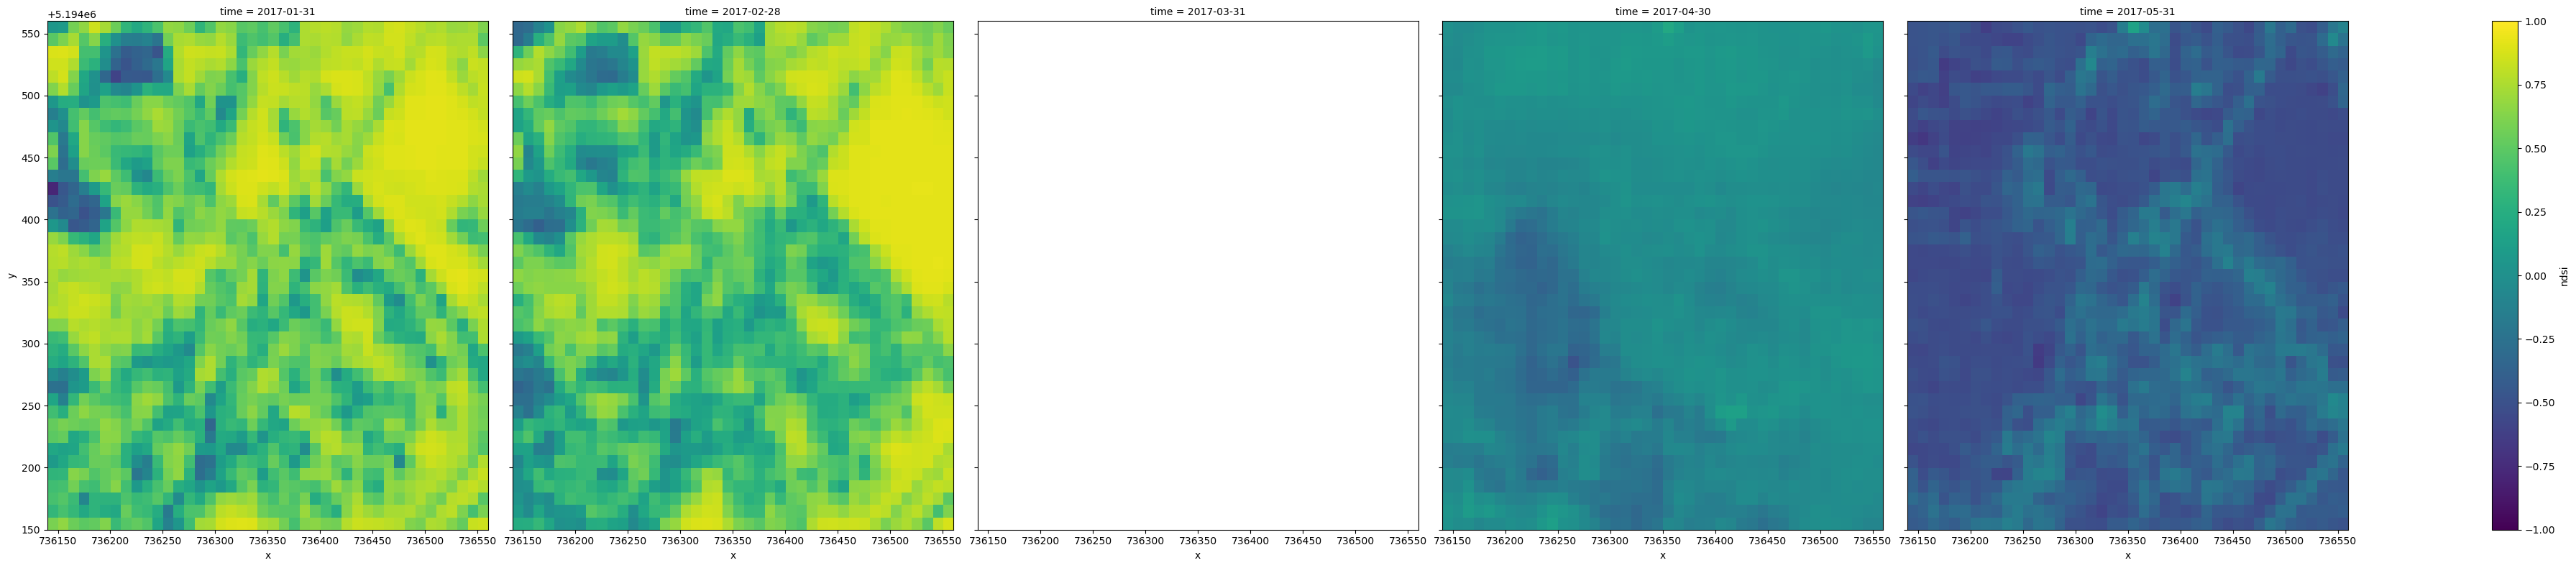

In [76]:
%%time
cube_s2['ndsi'].isel(time = slice(0,5)).plot.imshow(col="time", size=8, aspect=1, vmin = -1, vmax = 1)

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


CPU times: user 2.6 s, sys: 155 ms, total: 2.75 s
Wall time: 10.7 s


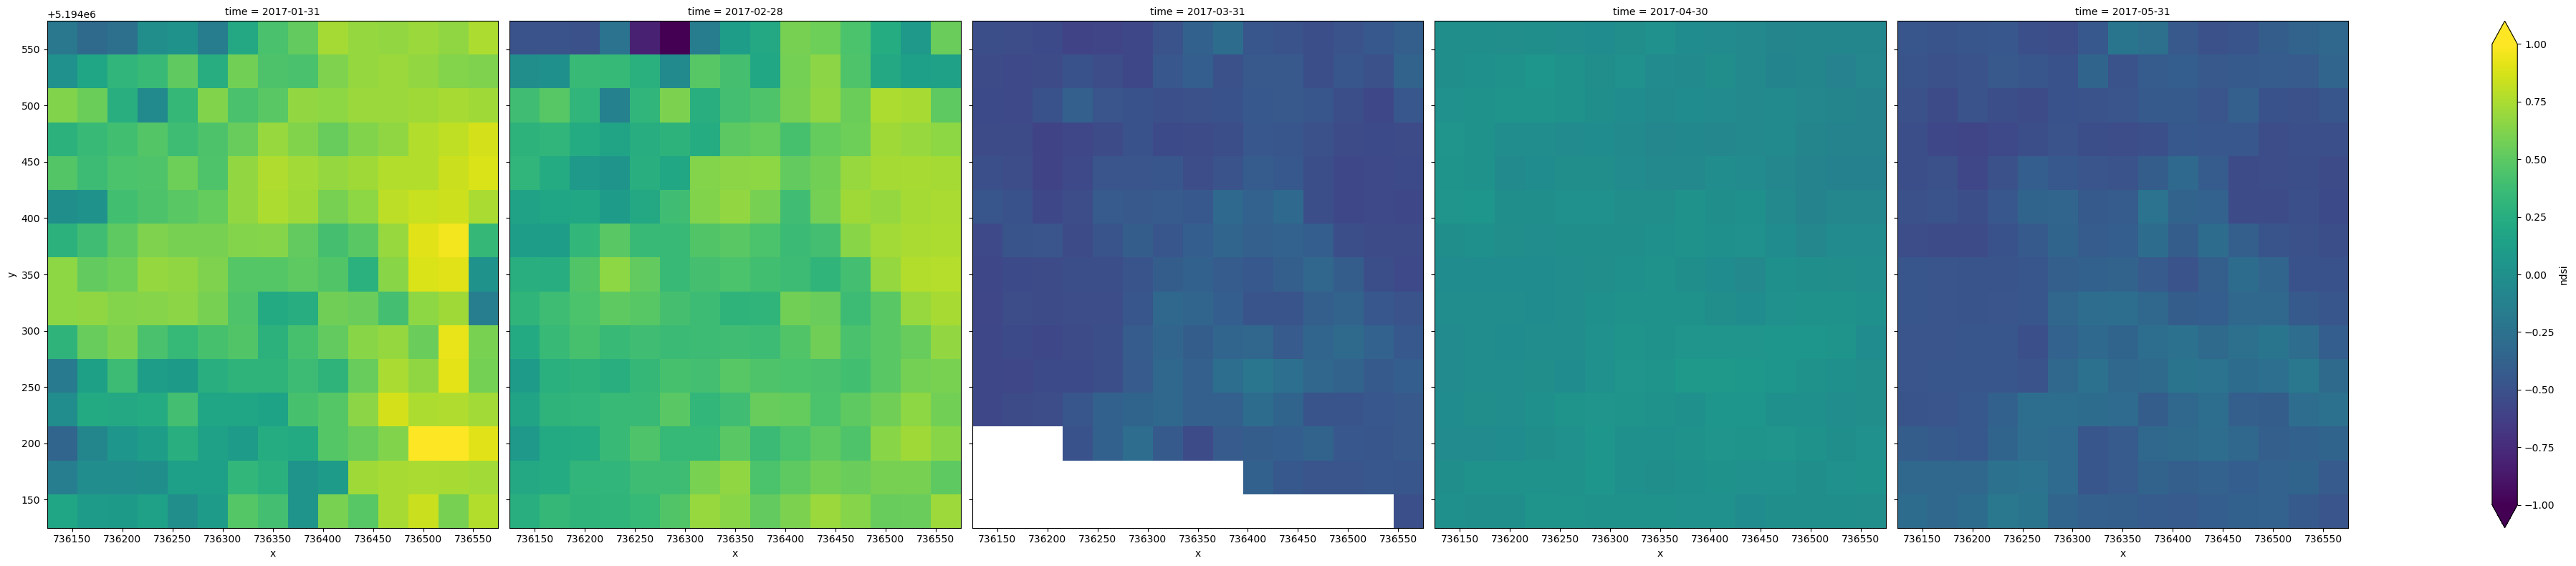

In [77]:
%%time
cube_ls['ndsi'].isel(time = slice(0,5)).plot.imshow(col="time", size=8, aspect=1, vmin = -1, vmax = 1)

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


CPU times: user 2.15 s, sys: 130 ms, total: 2.28 s
Wall time: 7.72 s


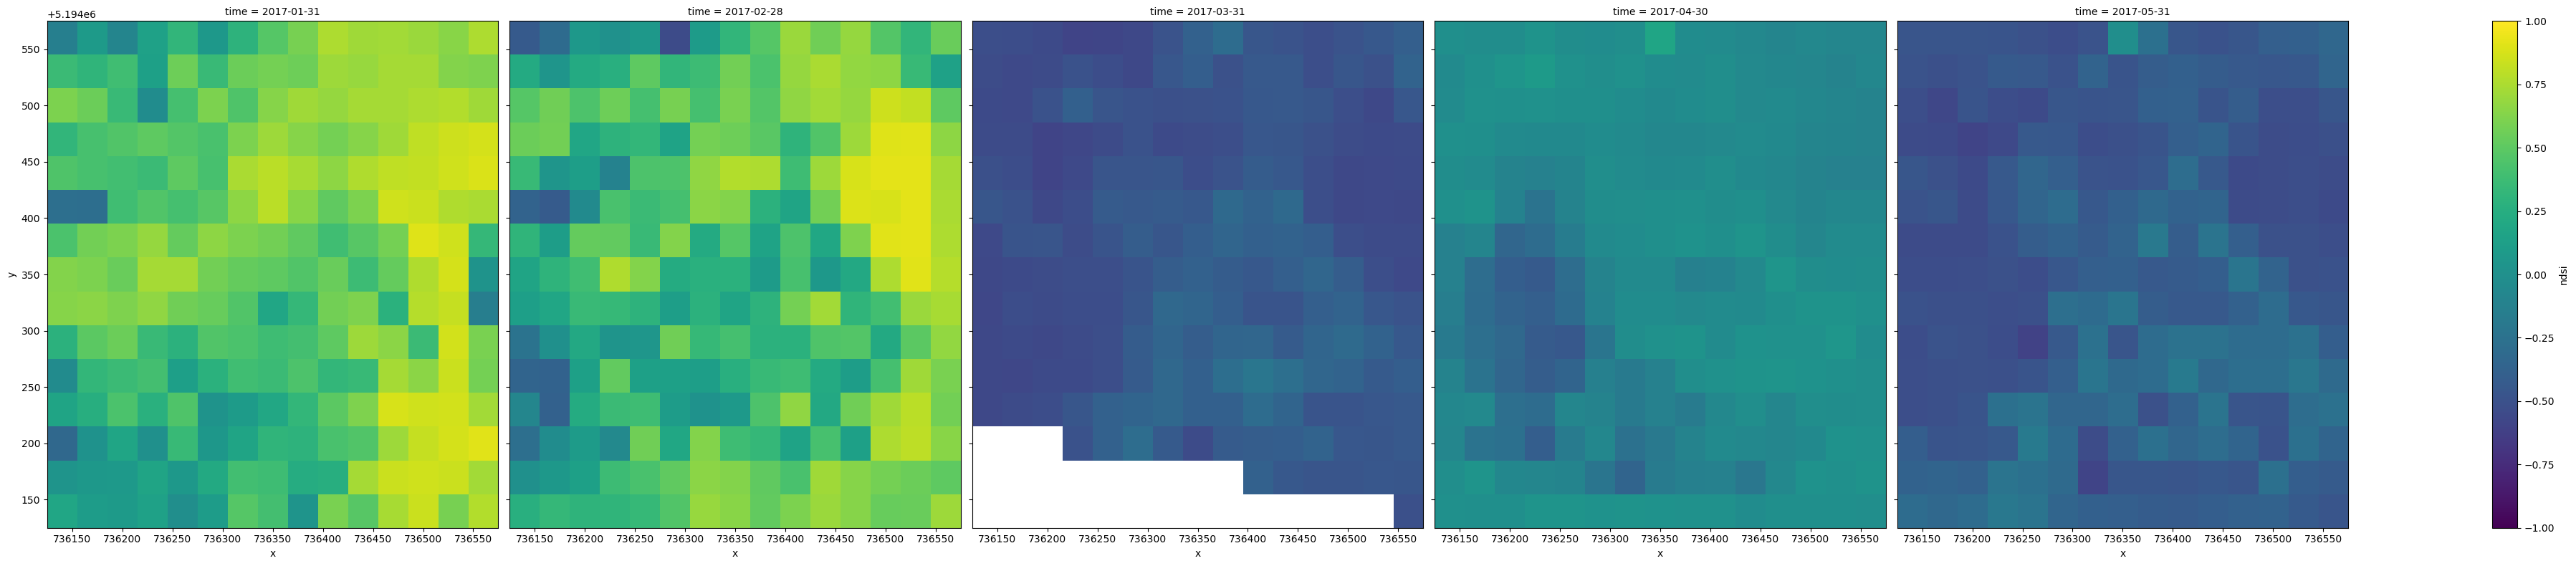

In [78]:
%%time
cube_mg['ndsi'].isel(time = slice(0,5)).plot.imshow(col="time", size=8, aspect=1, vmin = -1, vmax = 1)

Look at the values as well!

In [79]:
cube_mg.isel(time = slice(0,5)).load()

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


<xarray.Dataset> Size: 14kB
Dimensions:  (time: 5, y: 15, x: 15)
Coordinates:
  * y        (y) float64 120B 5.195e+06 5.195e+06 ... 5.194e+06 5.194e+06
  * x        (x) float64 120B 7.361e+05 7.362e+05 ... 7.365e+05 7.366e+05
  * time     (time) datetime64[ns] 40B 2017-01-31 2017-02-28 ... 2017-05-31
Data variables:
    swir16   (time, y, x) float32 4kB 0.3584 0.3606 0.3145 ... 0.2052 0.2241
    green    (time, y, x) float32 4kB 0.2711 0.4333 0.261 ... 0.08038 0.08104
    ndsi     (time, y, x) float32 4kB -0.1386 0.09157 ... -0.4372 -0.4688

**Aggregate Spatially**

Aggregate the cube spatially to get a time series for the whole period we chose. This is to check if the seasonality makes sense.

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


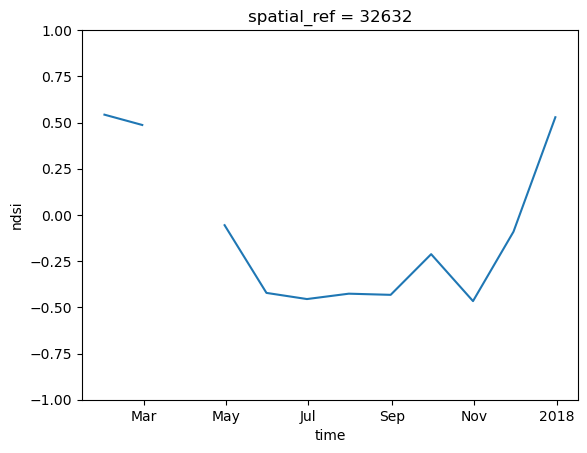

In [100]:
cube_s2['ndsi'].mean(dim=["x", "y"]).plot(ylim = [-1, 1])

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


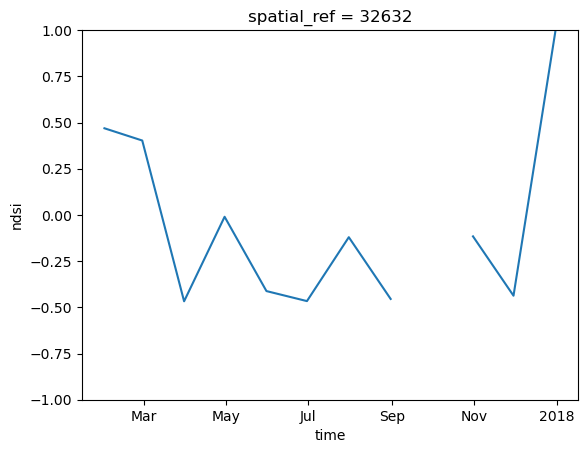

In [101]:
cube_ls['ndsi'].mean(dim=["x", "y"]).plot(ylim = [-1, 1])

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


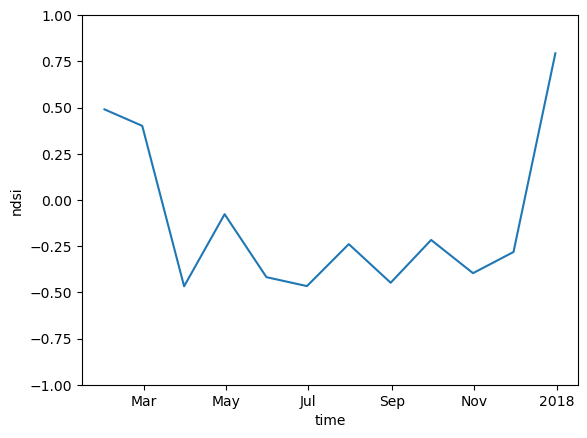

In [102]:
cube_mg['ndsi'].mean(dim=["x", "y"]).plot(ylim = [-1, 1])

### 4.3 Compare to station data
Get the snow depth data for the test station

In [103]:
aoi_tst

Name                           Anterselva_di_Mezzo_Osservatore
Longitude                                            12.100897
Latitude                                             46.860722
Elevation                                               1236.0
geometry     POLYGON ((12.103587999028658 46.86247066833042...
minx                                                 12.098205
miny                                                 46.858871
maxx                                                 12.103588
maxy                                                 46.862573
Name: 2508, dtype: object

Check what the actual measurements look like.

In [104]:
sd_mnth[(sd_mnth['Name']==aoi_tst.Name)].head()

,Name,year,month,HSmean_gapfill,time
1128,Anterselva_di_Mezzo_Osservatore,2000,1,21.258065,2000-01-31
1129,Anterselva_di_Mezzo_Osservatore,2000,2,18.103448,2000-02-29
1130,Anterselva_di_Mezzo_Osservatore,2000,3,7.935484,2000-03-31
1131,Anterselva_di_Mezzo_Osservatore,2000,4,0.033333,2000-04-30
1132,Anterselva_di_Mezzo_Osservatore,2000,5,0.000000,2000-05-31


Add a time column in date format that matches the date format in the data cube.

In [105]:
sd_mnth['time'] = pd.to_datetime(sd_mnth['year'].astype(str) + '-' + sd_mnth['month'].astype(str)) + pd.offsets.MonthEnd(0)

Filter to the chosen time range and station.

In [106]:
sd_tst = sd_mnth[(sd_mnth['Name']==aoi_tst.Name) & 
    (sd_mnth['time']>=cube_mg.time.min().values) & 
    (sd_mnth['time']<=cube_mg.time.max().values)]
sd_tst.head()

,Name,year,month,HSmean_gapfill,time
1332,Anterselva_di_Mezzo_Osservatore,2017,1,4.483871,2017-01-31
1333,Anterselva_di_Mezzo_Osservatore,2017,2,5.071429,2017-02-28
1334,Anterselva_di_Mezzo_Osservatore,2017,3,0.677419,2017-03-31
1335,Anterselva_di_Mezzo_Osservatore,2017,4,0.200000,2017-04-30
1336,Anterselva_di_Mezzo_Osservatore,2017,5,0.096774,2017-05-31


Convert the ndsi time series to a data frame.

In [107]:
%%time
df_ts = cube_mg['ndsi'].mean(dim=["x", "y"]).to_dataframe()
df_ts.head()

CPU times: user 411 ms, sys: 40.5 ms, total: 451 ms
Wall time: 1.87 s


/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


,ndsi
time,
2017-01-31,0.490028
2017-02-28,0.400765
2017-03-31,-0.467353
2017-04-30,-0.077225
2017-05-31,-0.418005


Join the two time series by date.

In [108]:
sd_tst = pd.merge(sd_tst, df_ts, on = "time")
sd_tst

,Name,year,month,HSmean_gapfill,time,ndsi
0,Anterselva_di_Mezzo_Osservatore,2017,1,4.483871,2017-01-31,0.490028
1,Anterselva_di_Mezzo_Osservatore,2017,2,5.071429,2017-02-28,0.400765
2,Anterselva_di_Mezzo_Osservatore,2017,3,0.677419,2017-03-31,-0.467353
3,Anterselva_di_Mezzo_Osservatore,2017,4,0.200000,2017-04-30,-0.077225
4,Anterselva_di_Mezzo_Osservatore,2017,5,0.096774,2017-05-31,-0.418005
5,Anterselva_di_Mezzo_Osservatore,2017,6,0.000000,2017-06-30,-0.466336
6,Anterselva_di_Mezzo_Osservatore,2017,7,0.000000,2017-07-31,-0.239151
7,Anterselva_di_Mezzo_Osservatore,2017,8,0.000000,2017-08-31,-0.448234
8,Anterselva_di_Mezzo_Osservatore,2017,9,0.000000,2017-09-30,-0.216606
9,Anterselva_di_Mezzo_Osservatore,2017,10,0.000000,2017-10-31,-0.396327


Plot their relationship (as a time series and as a scatter plot).

Text(0, 0.5, 'NDSI')

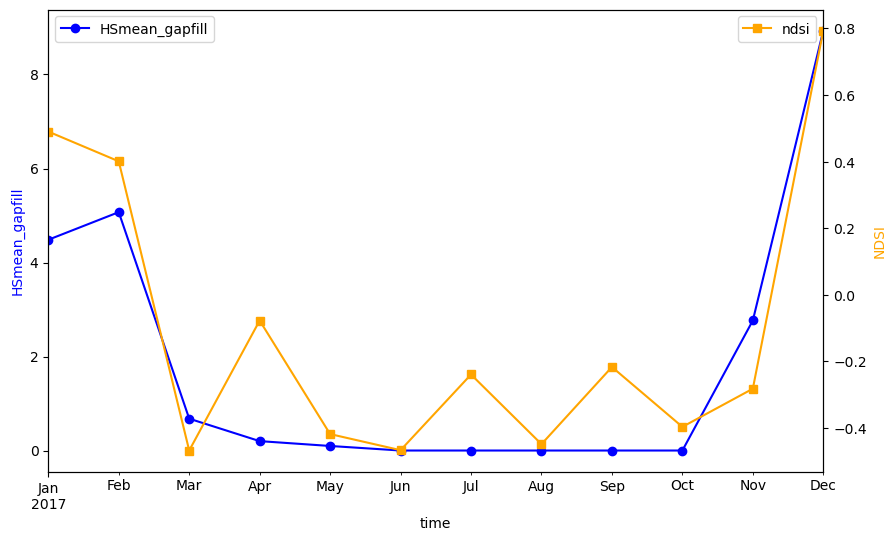

In [109]:
ax = sd_tst.plot(x="time", y="HSmean_gapfill", label="HSmean_gapfill", marker="o", color="blue", figsize=(10, 6))
ax.set_ylabel("HSmean_gapfill", color="blue")
ax.legend(loc="upper left")

ax2 = ax.twinx()
sd_tst.plot(x="time", y="ndsi", label="ndsi", marker="s", color="orange", ax=ax2)
ax2.set_ylabel("NDSI", color="orange")

<Axes: xlabel='ndsi', ylabel='HSmean_gapfill'>

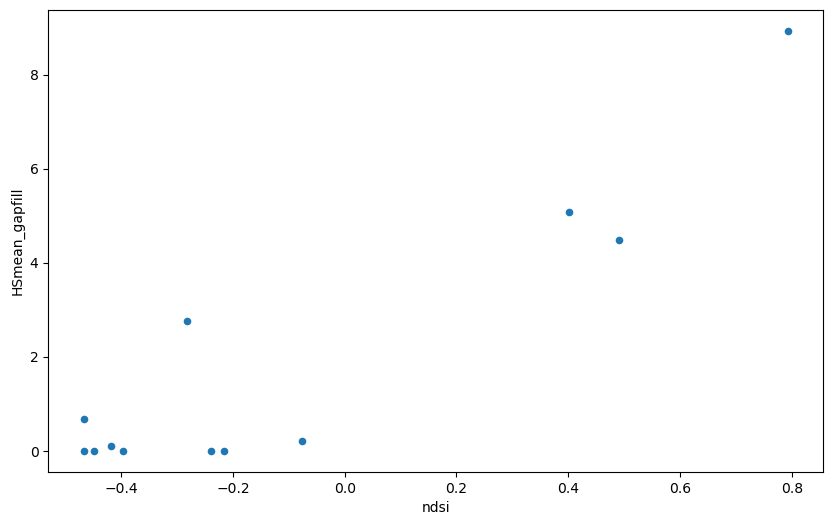

In [110]:
sd_tst.plot.scatter(x = "ndsi", y = "HSmean_gapfill", figsize=(10, 6))

Delete unneaded objects.

In [111]:
del(sd_tst)
del(df_ts)
del(cube_mg)
del(cube_s2_rep)
del(cube_ls)
del(cube_s2)

## 5. Scaling up to the full extent

#### 5.1 Defining the data cubes

Converting the bounding box of the station network we used above to a geodatframe

In [147]:
aoi = box(*bbox)
aoi = gpd.GeoDataFrame({"geometry": [aoi]}, crs="EPSG:4326")

Defining the Sentinel-2 data cube

In [148]:
%%time
bands = ["green", "swir16"] # s2 and ls share the same band names
chunk_size = 512

cube_s2 = odc_stac.load(items_s2,
                        geopolygon=aoi.geometry, 
                        groupby='solar_day',
                        chunks={"x": chunk_size, "y": chunk_size, "time": -1}, 
                        bands=bands,
                        resolution=60, # goint to 60 m resolution
)
cube_s2

CPU times: user 618 ms, sys: 47.6 ms, total: 666 ms
Wall time: 602 ms


<xarray.Dataset> Size: 2GB
Dimensions:      (y: 1181, x: 2434, time: 161)
Coordinates:
  * y            (y) float64 9kB 5.204e+06 5.204e+06 ... 5.134e+06 5.134e+06
  * x            (x) float64 19kB 6.12e+05 6.12e+05 ... 7.579e+05 7.58e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 1kB 2015-07-04T10:10:06.027000 ... 201...
Data variables:
    green        (time, y, x) uint16 926MB dask.array<chunksize=(161, 512, 512), meta=np.ndarray>
    swir16       (time, y, x) uint16 926MB dask.array<chunksize=(161, 512, 512), meta=np.ndarray>

Defining the Landsat data cube.

In [149]:
%%time
chunk_size = 512
cube_ls = odc_stac.load(items_ls,
                        geopolygon=aoi.geometry, 
                        groupby='solar_day',
                        chunks={"x": chunk_size, "y": chunk_size, "time": -1},
                        bands=bands, 
                        resolution = 60,
)
cube_ls

CPU times: user 10.2 s, sys: 1.17 s, total: 11.4 s
Wall time: 9.76 s


<xarray.Dataset> Size: 13GB
Dimensions:      (y: 1182, x: 2434, time: 1164)
Coordinates:
  * y            (y) float64 9kB 5.204e+06 5.204e+06 ... 5.134e+06 5.133e+06
  * x            (x) float64 19kB 6.12e+05 6.121e+05 ... 7.579e+05 7.58e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 9kB 2000-01-02T09:45:25.154075 ... 201...
Data variables:
    green        (time, y, x) uint16 7GB dask.array<chunksize=(1164, 512, 512), meta=np.ndarray>
    swir16       (time, y, x) uint16 7GB dask.array<chunksize=(1164, 512, 512), meta=np.ndarray>

#### 5.2 Scale and Offset

In [150]:
cube_s2 = scale_and_offset(cube_s2, scale = proto_dict['s2']['scale'], offset = proto_dict['s2']['offset'])
cube_ls = scale_and_offset(cube_ls, scale = proto_dict['ls']['scale'], offset = proto_dict['ls']['offset'])

#### 5.3 Merging the Cubes

Check the pixel sizes and crs of the cubes.

In [151]:
def pixel_size_crs(cube):
    x_p = np.diff(cube.x).mean()
    y_p = np.diff(cube.y).mean()
    cube_crs = cube.rio.crs
    print(x_p)
    print(y_p)
    print(cube_crs)

In [152]:
print(pixel_size_crs(cube = cube_s2))
print(pixel_size_crs(cube = cube_ls))

60.0
-60.0
EPSG:32632
None
60.0
-60.0
EPSG:32632
None


But, the pixels are not aligned. One has to be reprojected.

In [153]:
%%time
# takes forever, dask execution starts!
# cube_s2_rep = cube_s2.rio.reproject_match(cube_ls)

CPU times: user 7 μs, sys: 1e+03 ns, total: 8 μs
Wall time: 16.7 μs


Merge. And sort the time dimension.

In [154]:
cube_mg = xarray.concat([cube_ls, cube_s2], dim="time")
cube_mg = cube_mg.sortby("time") 

Resampling the grid of the landsat data cube to twice it's size, aggregating using max(). 
**This is a proxy for using the geometries to extract zonal statistics. It's more efficient.**

In [75]:
#cube_ls = cube_ls.coarsen(x=2, y=2, boundary="trim").max() # chunksize automatically halved.

In [76]:
#chunk_size = 1024
#cube_ls = cube_ls.chunk({"x": chunk_size, "y": chunk_size})

Resampling the grid of the s2 data cube to six times it's size (60 m), aggregating using max(). Then aligning to the landsat grid.

In [77]:
#cube_s2 = cube_s2.coarsen(x = 6, y = 6, boundary="trim").max() # interp(x=cube_ls["x"], y=cube_ls["y"])   # https://github.com/pydata/xarray/issues/6799 --> doesn't work on chunks!

In [78]:
#chunk_size = 1024
#cube_s2 = cube_s2.chunk({"x": chunk_size, "y": chunk_size})

#### 5.4 NDSI and temporal aggregation

Temporal resampling to one month and calculating ndsi. (**lazy**)

In [155]:
cube_s2 = aggregate_monthly_ndsi(cube = cube_s2)
cube_ls = aggregate_monthly_ndsi(cube = cube_ls)
cube_mg = aggregate_monthly_ndsi(cube = cube_mg)

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/array/core.py:5028: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/array/core.py:5028: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/array/core.py:5028: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/array/core.py:5028: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [156]:
cube_ls

<xarray.Dataset> Size: 8GB
Dimensions:      (y: 1182, x: 2434, time: 240)
Coordinates:
  * y            (y) float64 9kB 5.204e+06 5.204e+06 ... 5.134e+06 5.133e+06
  * x            (x) float64 19kB 6.12e+05 6.121e+05 ... 7.579e+05 7.58e+05
  * time         (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2019-12-31
    spatial_ref  int32 4B 32632
Data variables:
    green        (time, y, x) float32 3GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    swir16       (time, y, x) float32 3GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    ndsi         (time, y, x) float32 3GB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

### 5.4 Extract the ndsi at the stations

Extract the stations via xvec. In this workshop we are extracting the point locations. This is very efficient. That's why we have coarsened the resolution of our data cubes before. To simulate a spatial aggregation into zones. Using xvec zonal_statistics is possible but more costly.

In [157]:
sd_meta.geometry.centroid.head()

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_16504/1038952665.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sd_meta.geometry.centroid.head()


2508     POINT (12.1009 46.86072)
2510    POINT (11.31825 46.40558)
2514    POINT (10.72507 46.50906)
2515    POINT (11.78709 46.94142)
2517    POINT (12.05366 46.75974)
dtype: geometry

### Sentinel

In [158]:
ndsi_s2_points = cube_s2.xvec.extract_points(sd_meta.geometry.centroid, x_coords="x", y_coords="y", index=True)

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_16504/1322210221.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ndsi_s2_points = cube_s2.xvec.extract_points(sd_meta.geometry.centroid, x_coords="x", y_coords="y", index=True)


In [159]:
ndsi_s2_points

<xarray.Dataset> Size: 28kB
Dimensions:      (time: 54, geometry: 42)
Coordinates:
  * time         (time) datetime64[ns] 432B 2015-07-31 2015-08-31 ... 2019-12-31
    spatial_ref  int32 4B 32632
  * geometry     (geometry) object 336B POINT (12.100896641530436 46.86072178...
    index        (geometry) int64 336B 2508 2510 2514 2515 ... 2566 2567 2568
Data variables:
    green        (time, geometry) float32 9kB dask.array<chunksize=(1, 42), meta=np.ndarray>
    swir16       (time, geometry) float32 9kB dask.array<chunksize=(1, 42), meta=np.ndarray>
    ndsi         (time, geometry) float32 9kB dask.array<chunksize=(1, 42), meta=np.ndarray>
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

In [160]:
%%time
ndsi_s2_points = ndsi_s2_points["ndsi"].compute()

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **

CPU times: user 2.88 s, sys: 180 ms, total: 3.07 s
Wall time: 9.7 s


In [161]:
ndsi_s2_ts = ndsi_s2_points.to_dataframe(dim_order = ["geometry", "time"])

In [162]:
ndsi_s2_ts

spatial_ref  index  \
geometry                                     time                             
POINT (12.100896641530436 46.86072178371833) 2015-07-31        32632   2508   
                                             2015-08-31        32632   2508   
                                             2015-09-30        32632   2508   
                                             2015-10-31        32632   2508   
                                             2015-11-30        32632   2508   
...                                                              ...    ...   
POINT (11.397472601004155 46.55179479363155) 2019-08-31        32632   2568   
                                             2019-09-30        32632   2568   
                                             2019-10-31        32632   2568   
                                             2019-11-30        32632   2568   
                                             2019-12-31        32632   2568   

                                                             ndsi  
geometry                                     time                  
POINT (12.100896641530436 46.86072178371833) 2015-07-31       NaN  
                                             2015-08-31       NaN  
                                             2015-09-30       NaN  
                                             2015-10-31       NaN  
                                             2015-11-30       NaN  
...                                                           ...  
POINT (11.397472601004155 46.55179479363155) 2019-08-31 -0.218260  
                                             2019-09-30 -0.227949  
                                             2019-10-31  0.348315  
                                             2019-11-30  0.830891  
                                             2019-12-31  0.807803  

[2268 rows x 3 columns]

In [163]:
ndsi_s2_ts = ndsi_s2_ts.reset_index()
ndsi_s2_ts = pd.merge(ndsi_s2_ts, sd_meta[["Name", "Elevation"]], left_on="index", right_index=True)
ndsi_s2_ts = pd.merge(ndsi_s2_ts, sd_mnth, left_on = ["Name", "time"], right_on = ["Name", "time"])
ndsi_s2_ts = ndsi_s2_ts[["time", "Name", "index", "Elevation", "ndsi", "HSmean_gapfill"]]

array([[<Axes: title={'center': 'HSmean_gapfill'}>]], dtype=object)

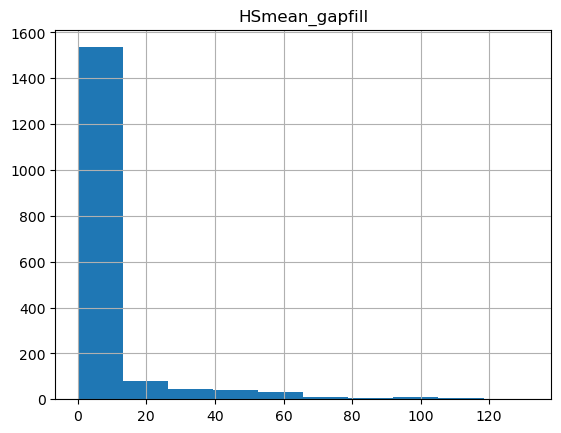

In [164]:
ndsi_s2_ts.hist("HSmean_gapfill")

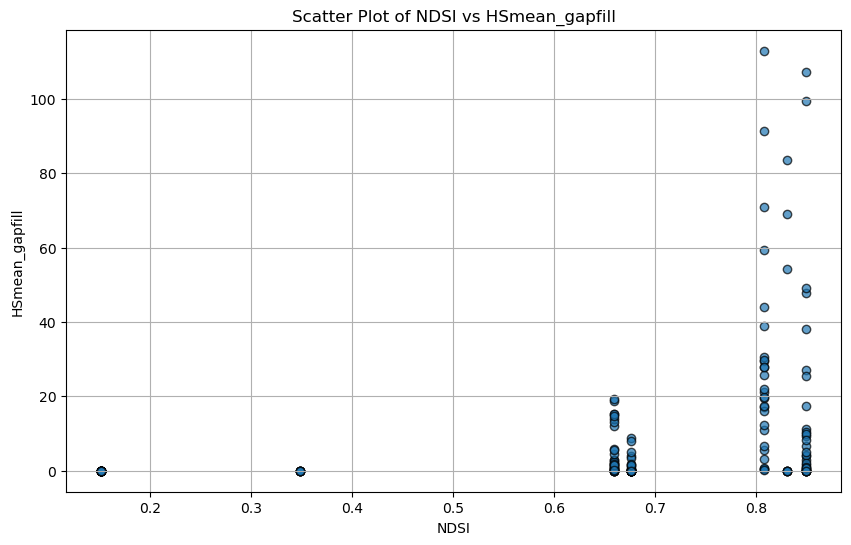

In [165]:
# Scatter plot
df = ndsi_s2_ts[ndsi_s2_ts['ndsi'] > 0] 
plt.figure(figsize=(10, 6))
plt.scatter(df['ndsi'], df['HSmean_gapfill'], alpha=0.7, edgecolors='k')

# Add labels and title
plt.xlabel('NDSI')
plt.ylabel('HSmean_gapfill')
plt.title('Scatter Plot of NDSI vs HSmean_gapfill')
plt.grid(True)
plt.show()

### Landsat

In [168]:
ndsi_ls_points = cube_ls.xvec.extract_points(sd_meta.geometry.centroid, x_coords="x", y_coords="y", index=True)

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_16504/1261333007.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ndsi_ls_points = cube_ls.xvec.extract_points(sd_meta.geometry.centroid, x_coords="x", y_coords="y", index=True)


In [169]:
ndsi_ls_points

<xarray.Dataset> Size: 124kB
Dimensions:      (time: 240, geometry: 42)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2019-12-31
    spatial_ref  int32 4B 32632
  * geometry     (geometry) object 336B POINT (12.100896641530436 46.86072178...
    index        (geometry) int64 336B 2508 2510 2514 2515 ... 2566 2567 2568
Data variables:
    green        (time, geometry) float32 40kB dask.array<chunksize=(1, 42), meta=np.ndarray>
    swir16       (time, geometry) float32 40kB dask.array<chunksize=(1, 42), meta=np.ndarray>
    ndsi         (time, geometry) float32 40kB dask.array<chunksize=(1, 42), meta=np.ndarray>
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

Convert to data frames, and combine the ndsi time series.

In [170]:
%%time
ndsi_ls_points = ndsi_ls_points.compute()

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/utils.py:77: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


CPU times: user 29.7 s, sys: 1.99 s, total: 31.7 s
Wall time: 1min 25s


In [171]:
ndsi_ls_ts = ndsi_ls_points.to_dataframe(dim_order = ["geometry", "time"])

In [172]:
ndsi_ls_ts

green    swir16  \
geometry                                     time                             
POINT (12.100896641530436 46.86072178371833) 2000-01-31  1.507832  0.106543   
                                             2000-02-29  1.201139  0.087801   
                                             2000-03-31  1.602212  0.098925   
                                             2000-04-30  1.602212  0.118918   
                                             2000-05-31       NaN       NaN   
...                                                           ...       ...   
POINT (11.397472601004155 46.55179479363155) 2019-08-31  0.187585  0.248951   
                                             2019-09-30  0.142595  0.233262   
                                             2019-10-31  0.425694  0.148892   
                                             2019-11-30       NaN       NaN   
                                             2019-12-31  1.388785  0.174055   

                                                         spatial_ref  \
geometry                                     time                      
POINT (12.100896641530436 46.86072178371833) 2000-01-31        32632   
                                             2000-02-29        32632   
                                             2000-03-31        32632   
                                             2000-04-30        32632   
                                             2000-05-31        32632   
...                                                              ...   
POINT (11.397472601004155 46.55179479363155) 2019-08-31        32632   
                                             2019-09-30        32632   
                                             2019-10-31        32632   
                                             2019-11-30        32632   
                                             2019-12-31        32632   

                                                             ndsi  index  
geometry                                     time                         
POINT (12.100896641530436 46.86072178371833) 2000-01-31  0.868008   2508  
                                             2000-02-29  0.863762   2508  
                                             2000-03-31  0.883695   2508  
                                             2000-04-30  0.861815   2508  
                                             2000-05-31       NaN   2508  
...                                                           ...    ...  
POINT (11.397472601004155 46.55179479363155) 2019-08-31 -0.140575   2568  
                                             2019-09-30 -0.241228   2568  
                                             2019-10-31  0.481740   2568  
                                             2019-11-30       NaN   2568  
                                             2019-12-31  0.777258   2568  

[10080 rows x 5 columns]

Merge snowdepth data. First metadata, then snow depth.

In [173]:
ndsi_ls_ts = ndsi_ls_ts.reset_index()
ndsi_ls_ts = pd.merge(ndsi_ls_ts, sd_meta[["Name", "Elevation"]], left_on="index", right_index=True)
ndsi_ls_ts = pd.merge(ndsi_ls_ts, sd_mnth, left_on = ["Name", "time"], right_on = ["Name", "time"])
ndsi_ls_ts = ndsi_ls_ts[["time", "Name", "index", "Elevation", "ndsi", "HSmean_gapfill"]]

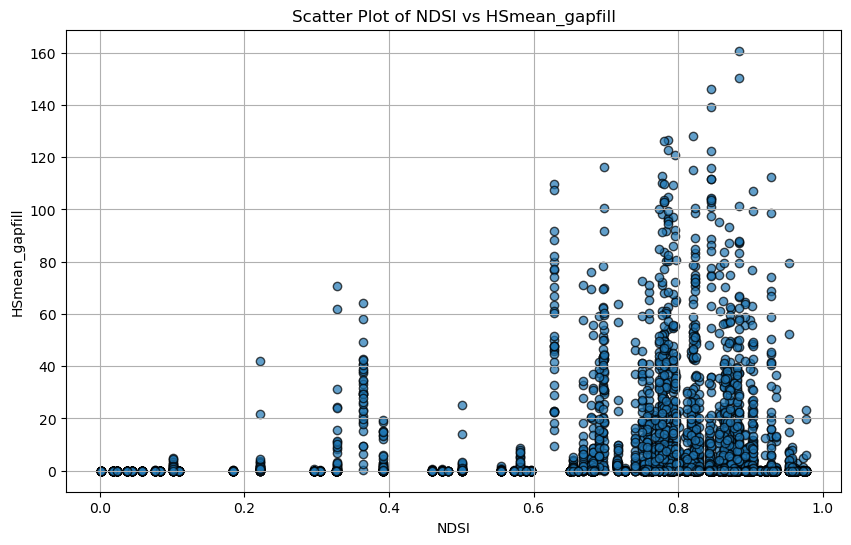

In [174]:
# Scatter plot
df = ndsi_ls_ts[ndsi_ls_ts['ndsi'] > 0] 
plt.figure(figsize=(10, 6))
plt.scatter(df['ndsi'], df['HSmean_gapfill'], alpha=0.7, edgecolors='k')

# Add labels and title
plt.xlabel('NDSI')
plt.ylabel('HSmean_gapfill')
plt.title('Scatter Plot of NDSI vs HSmean_gapfill')
plt.grid(True)
plt.show()

### Merged Cube


In [175]:
ndsi_mg_points = cube_mg.xvec.extract_points(sd_meta.geometry.centroid, x_coords="x", y_coords="y", index=True)

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_16504/433136898.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ndsi_mg_points = cube_mg.xvec.extract_points(sd_meta.geometry.centroid, x_coords="x", y_coords="y", index=True)


In [176]:
ndsi_mg_points

<xarray.Dataset> Size: 124kB
Dimensions:      (time: 240, geometry: 42)
Coordinates:
  * time         (time) datetime64[ns] 2kB 2000-01-31 2000-02-29 ... 2019-12-31
    spatial_ref  int32 4B 32632
  * geometry     (geometry) object 336B POINT (12.100896641530436 46.86072178...
    index        (geometry) int64 336B 2508 2510 2514 2515 ... 2566 2567 2568
Data variables:
    green        (time, geometry) float32 40kB dask.array<chunksize=(1, 42), meta=np.ndarray>
    swir16       (time, geometry) float32 40kB dask.array<chunksize=(1, 42), meta=np.ndarray>
    ndsi         (time, geometry) float32 40kB dask.array<chunksize=(1, 42), meta=np.ndarray>
Indexes:
    geometry  GeometryIndex (crs=EPSG:4326)

In [177]:
%%time
ndsi_mg_points = ndsi_mg_points.compute()

2024-12-06 18:22:53,440 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.45 GiB -- Worker memory limit: 4.00 GiB
2024-12-06 18:23:20,552 - distributed.worker.memory - WARNING - Worker is at 86% memory usage. Pausing worker.  Process memory: 3.45 GiB -- Worker memory limit: 4.00 GiB
2024-12-06 18:23:20,935 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:45053 -> tcp://127.0.0.1:32887
Traceback (most recent call last):
  File "/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/tornado/ios

KilledWorker: Attempted to run task ('where-db49a34a4214cc0c62d9075a74528442', 0, 0, 0) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:38403. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2024-12-06 18:28:13,544 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.80 GiB -- Worker memory limit: 4.00 GiB


In [127]:
ndsi_mg_ts = ndsi_mg_points.to_dataframe(dim_order = ["geometry", "time"])

In [130]:
ndsi_mg_ts

,time,Name,index,Elevation,ndsi,HSmean_gapfill
0,2000-01-31,Anterselva_di_Mezzo_Osservatore,2508,1236.0,NaN,21.258065
1,2000-02-29,Anterselva_di_Mezzo_Osservatore,2508,1236.0,NaN,18.103448
2,2000-03-31,Anterselva_di_Mezzo_Osservatore,2508,1236.0,NaN,7.935484
3,2000-04-30,Anterselva_di_Mezzo_Osservatore,2508,1236.0,NaN,0.033333
4,2000-05-31,Anterselva_di_Mezzo_Osservatore,2508,1236.0,NaN,0.000000
...,...,...,...,...,...,...
10075,2019-08-31,Vanga_Osservatore,2568,920.0,NaN,0.000000
10076,2019-09-30,Vanga_Osservatore,2568,920.0,NaN,0.000000
10077,2019-10-31,Vanga_Osservatore,2568,920.0,NaN,0.000000
10078,2019-11-30,Vanga_Osservatore,2568,920.0,NaN,0.000000


In [128]:
ndsi_mg_ts = ndsi_mg_ts.reset_index()
ndsi_mg_ts = pd.merge(ndsi_mg_ts, sd_meta[["Name", "Elevation"]], left_on="index", right_index=True)
ndsi_mg_ts = pd.merge(ndsi_mg_ts, sd_mnth, left_on = ["Name", "time"], right_on = ["Name", "time"])
ndsi_mg_ts = ndsi_mg_ts[["time", "Name", "index", "Elevation", "ndsi", "HSmean_gapfill"]]

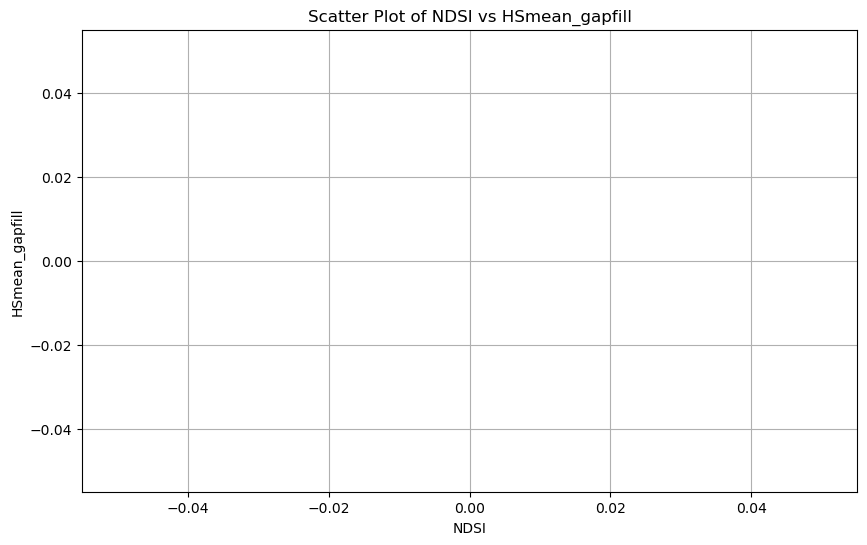

In [129]:
# Scatter plot
df = ndsi_mg_ts[ndsi_mg_ts['ndsi'] > 0] 
plt.figure(figsize=(10, 6))
plt.scatter(df['ndsi'], df['HSmean_gapfill'], alpha=0.7, edgecolors='k')

# Add labels and title
plt.xlabel('NDSI')
plt.ylabel('HSmean_gapfill')
plt.title('Scatter Plot of NDSI vs HSmean_gapfill')
plt.grid(True)
plt.show()

### 5.x Excursion: Extract via zonal_statistics

In [59]:
# replace nan with -2, then use normal rasterization
# ndsi_s2 = ndsi_s2.fillna(-2)
#print(sd_meta.crs)
#sd_meta_rep = sd_meta.to_crs(ndsi_s2.rio.crs)
#print(sd_meta_rep.crs)

In [ ]:
#%%time
#ndsi_s2_zonal = ndsi_s2.isel(time=slice(None, 5)).xvec.zonal_stats(
#    list(sd_meta.geometry[0:5]), x_coords="x", y_coords="y", stats="max", 
#    method="iterate",
#    n_jobs=-1,
#    index=True,
#)
ndsi_s2_zonal


## Outlook
Next steps in this workflow could be:

- Test an example where the stations are spread out over the globe.
- Include cloud and quality maksing to get more robust results.
- Use static information like elevation, aspect etc.
- Apply more sophisticated machine learning:
    - Time series prediction (extrapolation in time)
    - Mapping (extrapolation in space)
- Add more features (e.g. ERA5, S1) and do a mulitvariate analysis.
- Find solution for xvec.zonal_stats(method="rasterize")
- try depth first approach (loop through workflow in prototyping)